# Run Models on RC

## RC Setup

[Docs for RC](https://curc.readthedocs.io/en/latest/index.html)

* Make a script for running Slurm job (see `../rc_scripts/plasma_nns_1.sh`)
    * See [job scripting](https://curc.readthedocs.io/en/latest/running-jobs/batch-jobs.html) and [the alpine partitions](https://curc.readthedocs.io/en/latest/clusters/alpine/alpine-hardware.html)
* Make relevant data and output dirs in `/projects/${USER}/` and `/scratch/{alpine,blanca}/${USER}/`

Getting python (anaconda ugh) to work:

* Folow [these Conda instructions](https://curc.readthedocs.io/en/latest/software/python.html)
* Install all packages from the reqiurements.txt, with special for pytorch/numpy/etc:
    * `conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia`
    * `conda install -c conda-forge papermill`
* Export the made conda evironment for future use:
    * `conda env export --from-history --no-builds --name nnenv > conda_env.yml`
* Make sure RC slurm job script has conda relevant lines:
    * `module load anaconda`
    * `conda activate nnenv`

OLD Instructions for python (didn't work):

* ~~Have python install to different directory other than home (not enough space)~~
    * ~~update `~/.config/pip/pip.conf` with `target`~~
* ~~Add to `.bash_profile`:~~
    * ```bash
        # Add custom python lib to path
        PATH=/projects/bhjo6995/python_lib/bin:$PATH
      ```


### Running and monitoring job

* `sbatch JOBNAME.sh`
* `squeue --user=bhjo6995 --long --start`


### Debugging job script

* `sinteractive --partition=amc --time=00:40:00 --ntasks=1 --gres=gpu:1 --constraint=gpu`
* Or [this link]() is faster somehow (and with GUI)

## Notebook Setup

In [1]:
# Required packages
#!pip install "../reqiurements.txt"

In [2]:
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [3]:
## Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "lib"))

In [4]:
from models.simpleFork import Simple, Fork
from models.danmf import DANMF
from models.convmf import ConvMF
from datasets.gen_plasma_1d import GenPlasma1DDataset
from framework.saveload import load_checkpoint, load_trained_model
from framework.params import * # device, use_cuda, Checkpoint, various saving strs
from framework.train import train_model

from timeit import default_timer
import re
from datetime import datetime
import json

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, diagsvd
from torch import nn
from torch.utils.data import DataLoader, random_split
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import profiler

### Per-run user defined variables

In [5]:
# Define the machine being used
machine = "RC"

# Paths for files
data_dir = os.path.normpath("/scratch/alpine/bhjo6995/data/")
output_dir = os.path.normpath("/projects/bhjo6995/output")
tensorboard_dir = os.path.join(output_dir, "tensorboard")

# Dataset params
batch_size = 25
mat_size = [64, 128]
mat_dirs = [os.path.join(data_dir, "gen_plasma_n64", f"mat_{i}") for i in range(3)]

# Device comes from framework.params
print(f"Using {device} device")

Using cuda device


## Data 

Data generated from the matlab code `gen_data_matlab/SSPML_CWENO_ht1d.m`

#### Normalization
* No normalization (too expensive?)

### Dataset

In [6]:
# Load and split the data, and prep for being fed into the NN
data = GenPlasma1DDataset(mat_dirs)
# Divide data into train, validation, test
train_data, validation_data, test_data = random_split(data, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

21975 <class 'torch.Tensor'> torch.Size([64, 128])


tensor([[ 1.5490e-09,  1.2974e-08, -1.2685e-09,  ..., -3.1265e-08,
          2.4354e-08, -4.3778e-09],
        [ 8.8028e-09,  6.6438e-09,  1.6978e-08,  ..., -1.7247e-08,
          1.6309e-08,  3.0742e-10],
        [ 1.4042e-08,  5.9671e-09,  2.7655e-08,  ...,  1.7584e-08,
         -6.1634e-10,  7.9415e-09],
        ...,
        [ 2.9151e-10,  1.6614e-08, -1.7626e-08,  ...,  1.8026e-08,
          6.2687e-09,  8.9249e-09],
        [-4.8291e-09,  2.5087e-08, -3.2353e-08,  ..., -1.9762e-09,
          1.3646e-08,  1.1134e-09],
        [-4.2047e-09,  2.1915e-08, -2.2832e-08,  ..., -2.3230e-08,
          2.2154e-08, -4.1802e-09]])


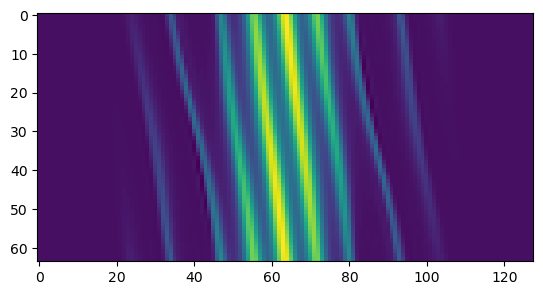

In [7]:
plt.imshow(data[2669])
print(len(data), type(data[0]), data[244].shape)
print(data[2000])

## Hyperparameters

### Loss Function
We use methods defined in [[1]](#r1) to define our loss function <!-- $\mathcal{L}$ \\ -->

$$
\min_{\substack{U \in \real^{m\times r} \\ V \in \real^{r\times n}}} ||X - ReLU(UV)||^2_F ,
$$
Where we are finding the square Frobenius norm of the difference between the original matrix $X$ and the rectified linear low rank representation matrices $UV$

### Optimizer

Adam works fine / is standard



## Model Definition

### Multiple models hyperparams

In [8]:
## Params
ranks = [6, 12]

stem_layer_dims = [500, 200]

fork_layer_dims = [200, 300]

conv_dims = [[5, 1, 3, 1], [3, 1, 0, 1]]

run_params = dict(
                epochs=120,
                checkpoint_at=40,
                batch_pr=40,
                batch_size=batch_size,
                runname="plasma_mf_test_1"
                )


# Save details
run_details = {"run_params": run_params}
runname = run_details["run_params"]["runname"]
output_run_dir = os.path.join(output_dir, f"run_{runname}")

### Models Creation

In [9]:
models = []

for r in ranks:
    m = Fork(r, mat_size, stem_layer_dims, fork_layer_dims).to(device)
    print(f"{m.get_name()} \trank = {r} \t sl={stem_layer_dims} \t fl={fork_layer_dims} \tcl={0}")
    models.append(m)
    run_details[m.get_name()] = m.get_hyperparameters()

    m = ConvMF(r, mat_size, stem_layer_dims, fork_layer_dims, conv_dims).to(device)
    print(f"{m.get_name()} \trank = {r} \t sl={stem_layer_dims} \t fl={fork_layer_dims} \tcl={conv_dims}")
    models.append(m)
    run_details[m.get_name()] = m.get_hyperparameters()

Fork_img64_sdim2-3ebc_fdim2-37e7 	rank = 6 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_img64_cdim2-c00f 	rank = 6 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_r12_img64_sdim2-3ebc_fdim2-37e7 	rank = 12 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r12_img64_cdim2-c00f 	rank = 12 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]


## Run models

In [10]:
if not os.path.exists(output_run_dir):
    os.mkdir(output_run_dir)

# Save details
with open(os.path.join(output_run_dir, f"details_{runname}.json"), "w" ) as write:
    json.dump(run_details, write, indent=2 )


for model in models:
    writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_model(model=model, 
                optimizer=optimizer,
                train_data=train_dataloader,
                validate_data=validation_dataloader,
                output_run_dir=output_run_dir,
                **run_details["run_params"], 
                writer=writer, 
                load=False
               )
    writer.close()

Training Fork_img64_sdim2-3ebc_fdim2-37e7


[0, 40] loss: 86.31832971572877, validation loss: 32.014702137538364, average train time (sec): 4.213973879814148e-05


[0, 80] loss: 26.460999250411987, validation loss: 23.7250724029541, average train time (sec): 4.263394512236118e-05


[0, 120] loss: 22.115288639068602, validation loss: 22.208844364711215, average train time (sec): 4.2202812619507315e-05


[0, 160] loss: 20.949803161621094, validation loss: 21.33151659284319, average train time (sec): 4.151752218604088e-05


[0, 200] loss: 20.517837715148925, validation loss: 18.12734953199114, average train time (sec): 4.220607224851847e-05


[0, 240] loss: 13.833842158317566, validation loss: 10.33178080695016, average train time (sec): 4.1814870201051235e-05


[0, 280] loss: 8.45618212223053, validation loss: 6.681703679221017, average train time (sec): 4.466522950679064e-05


[0, 320] loss: 6.00794153213501, validation loss: 5.422843878609793, average train time (sec): 4.2606890201568606e-05


[0, 360] loss: 5.068859827518463, validation loss: 4.759476859228951, average train time (sec): 4.36300178989768e-05


[0, 400] loss: 4.474493563175201, validation loss: 4.3018197904314315, average train time (sec): 4.570565652102232e-05


[0, 440] loss: 4.0083976745605465, validation loss: 3.9453151825496127, average train time (sec): 4.458755720406771e-05


[0, 480] loss: 3.754736804962158, validation loss: 3.6899303885868617, average train time (sec): 4.235664382576942e-05


[0, 520] loss: 3.6090125501155854, validation loss: 3.510859338215419, average train time (sec): 4.891599528491497e-05


[0, 560] loss: 3.413677054643631, validation loss: 3.6319652693612237, average train time (sec): 4.439123440533876e-05


[0, 600] loss: 3.1997396767139437, validation loss: 3.239739442552839, average train time (sec): 4.1876244358718397e-05


[1, 40] loss: 3.1204268872737884, validation loss: 3.0369491713387626, average train time (sec): 4.6153157018125055e-05


[1, 80] loss: 2.9123632669448853, validation loss: 2.9491226073673795, average train time (sec): 4.631644114851952e-05


[1, 120] loss: 2.8520505368709563, validation loss: 2.855945611681257, average train time (sec): 4.5188586227595806e-05


[1, 160] loss: 2.7744981586933135, validation loss: 2.8135696029663086, average train time (sec): 4.1437172330915925e-05


[1, 200] loss: 2.7110728204250334, validation loss: 2.6754527854919434, average train time (sec): 4.322428721934557e-05


[1, 240] loss: 2.6401875972747804, validation loss: 2.5782224546160015, average train time (sec): 4.340962041169405e-05


[1, 280] loss: 2.5322149813175203, validation loss: 2.478656303542001, average train time (sec): 4.4971518218517306e-05


[1, 320] loss: 2.446066901087761, validation loss: 2.433150495801653, average train time (sec): 4.324174951761961e-05


[1, 360] loss: 2.436983397603035, validation loss: 2.289146275520325, average train time (sec): 4.647006280720234e-05


[1, 400] loss: 2.1607127368450163, validation loss: 2.1838754844665527, average train time (sec): 4.36900882050395e-05


[1, 440] loss: 2.2545597851276398, validation loss: 2.196405124664307, average train time (sec): 4.176045767962932e-05


[1, 480] loss: 2.1442097991704943, validation loss: 2.0717030327660697, average train time (sec): 4.20555705204606e-05


[1, 520] loss: 2.0520078212022783, validation loss: 1.9599628244127547, average train time (sec): 4.364482592791319e-05


[1, 560] loss: 1.9547689586877823, validation loss: 1.8863551024028233, average train time (sec): 4.2486889287829396e-05


[1, 600] loss: 1.8271396547555923, validation loss: 1.822695324761527, average train time (sec): 5.541287828236818e-05


[2, 40] loss: 1.85205919444561, validation loss: 1.7837939834594727, average train time (sec): 4.4065341353416446e-05


[2, 80] loss: 1.7987928509712219, validation loss: 1.6957222815922328, average train time (sec): 4.42414078861475e-05


[2, 120] loss: 1.629289272427559, validation loss: 1.6466506842204502, average train time (sec): 4.607734736055136e-05


[2, 160] loss: 1.673286920785904, validation loss: 1.6371848494665964, average train time (sec): 4.364182241261006e-05


[2, 200] loss: 1.6843667566776275, validation loss: 1.591183888571603, average train time (sec): 4.486581310629845e-05


[2, 240] loss: 1.698159858584404, validation loss: 1.6215487016950334, average train time (sec): 4.242551513016224e-05


[2, 280] loss: 1.8412066459655763, validation loss: 1.6832684605462211, average train time (sec): 4.33577224612236e-05


[2, 320] loss: 1.5311412394046784, validation loss: 1.470394550051008, average train time (sec): 4.485859535634518e-05


[2, 360] loss: 1.4319812387228013, validation loss: 1.425460388319833, average train time (sec): 6.0272286646068096e-05


[2, 400] loss: 1.3704465478658676, validation loss: 1.3736484622955323, average train time (sec): 4.073355812579393e-05


[2, 440] loss: 1.349163357913494, validation loss: 1.3829053350857325, average train time (sec): 4.422410856932402e-05


[2, 480] loss: 1.3650873959064485, validation loss: 1.3389233037403652, average train time (sec): 4.3349224142730236e-05


[2, 520] loss: 1.309694954752922, validation loss: 1.3047172147887094, average train time (sec): 4.4828001409769056e-05


[2, 560] loss: 1.2678778365254402, validation loss: 1.2961847904750279, average train time (sec): 4.262360744178295e-05


[2, 600] loss: 1.2548625856637954, validation loss: 1.2466260266304017, average train time (sec): 4.27538063377142e-05


[3, 40] loss: 1.2348560616374016, validation loss: 1.2107455910955156, average train time (sec): 4.293443635106087e-05


[3, 80] loss: 1.1606206342577934, validation loss: 1.1636946146828788, average train time (sec): 4.3315114453434944e-05


[3, 120] loss: 1.192424127459526, validation loss: 1.2276398015022278, average train time (sec): 5.504791624844074e-05


[3, 160] loss: 1.1663832664489746, validation loss: 1.14538330248424, average train time (sec): 4.2764353565871716e-05


[3, 200] loss: 1.1398466765880584, validation loss: 1.1214461731910705, average train time (sec): 4.501082003116608e-05


[3, 240] loss: 1.0971774637699128, validation loss: 1.0883769614355905, average train time (sec): 4.3708132579922676e-05


[3, 280] loss: 1.084399911761284, validation loss: 1.0436972846303667, average train time (sec): 4.255471285432577e-05


[3, 320] loss: 1.0746184274554254, validation loss: 1.0917263490813118, average train time (sec): 4.3693347834050655e-05


[3, 360] loss: 1.0869726940989495, validation loss: 1.049522863796779, average train time (sec): 4.785142373293638e-05


[3, 400] loss: 0.9916176959872246, validation loss: 1.073541543143136, average train time (sec): 4.3249246664345266e-05


[3, 440] loss: 1.0363073110580445, validation loss: 1.0019155836105347, average train time (sec): 4.9487734213471415e-05


[3, 480] loss: 0.9702587619423866, validation loss: 0.9839972387041365, average train time (sec): 4.637837409973145e-05


[3, 520] loss: 1.0063175201416015, validation loss: 1.0127598507063729, average train time (sec): 4.5333453454077247e-05


[3, 560] loss: 1.1245311185717584, validation loss: 1.0514182799203056, average train time (sec): 4.223885480314493e-05


[3, 600] loss: 0.9262916728854179, validation loss: 0.9386683280127389, average train time (sec): 4.4133164919912815e-05


[4, 40] loss: 0.9274834603071213, validation loss: 0.8829673552513122, average train time (sec): 4.281769506633282e-05


[4, 80] loss: 0.9087383657693863, validation loss: 0.8727255514689854, average train time (sec): 4.576952196657658e-05


[4, 120] loss: 0.8777293890714646, validation loss: 0.8917136120796204, average train time (sec): 4.1843904182314875e-05


[4, 160] loss: 0.8427741333842278, validation loss: 0.8441681841441563, average train time (sec): 4.2946217581629754e-05


[4, 200] loss: 0.8603144600987435, validation loss: 0.819406737940652, average train time (sec): 4.263161681592464e-05


[4, 240] loss: 0.7926632180809975, validation loss: 0.8141836193629673, average train time (sec): 4.3022586032748224e-05


[4, 280] loss: 0.7994137771427632, validation loss: 0.8429233707700456, average train time (sec): 4.3203658424317834e-05


[4, 320] loss: 0.7993356555700302, validation loss: 0.7975949362346104, average train time (sec): 5.8981822803616524e-05


[4, 360] loss: 0.8874454036355018, validation loss: 0.9083391761779785, average train time (sec): 6.239227950572967e-05


[4, 400] loss: 1.1264191299676896, validation loss: 0.9978510410445077, average train time (sec): 5.201478488743305e-05


[4, 440] loss: 0.8701757401227951, validation loss: 0.805018994808197, average train time (sec): 5.4307072423398496e-05


[4, 480] loss: 0.8164496913552284, validation loss: 0.7922059864657266, average train time (sec): 4.4608069583773616e-05


[4, 520] loss: 0.7944281592965126, validation loss: 0.7552881520135062, average train time (sec): 5.141058936715126e-05


[4, 560] loss: 0.7590938299894333, validation loss: 0.7416701565470014, average train time (sec): 5.1000830717384814e-05


[4, 600] loss: 0.721077473461628, validation loss: 0.7396784458841597, average train time (sec): 5.3173420019447805e-05


[5, 40] loss: 0.7722405567765236, validation loss: 0.7662222346237727, average train time (sec): 5.023190751671791e-05


[5, 80] loss: 0.7134084090590477, validation loss: 0.7173521859305245, average train time (sec): 5.2665709517896175e-05


[5, 120] loss: 0.7229156918823719, validation loss: 0.7194382279259818, average train time (sec): 5.2950484678149225e-05


[5, 160] loss: 0.7571519002318382, validation loss: 0.7145246916157859, average train time (sec): 5.254021380096674e-05


[5, 200] loss: 0.6857206240296364, validation loss: 0.7367348664147513, average train time (sec): 5.5433530360460284e-05


[5, 240] loss: 0.7209179311990738, validation loss: 0.7213740359033857, average train time (sec): 5.627910140901804e-05


[5, 280] loss: 0.733877657353878, validation loss: 0.7116240453720093, average train time (sec): 5.6493422016501425e-05


[5, 320] loss: 0.7295798748731613, validation loss: 0.7059382614067623, average train time (sec): 4.414219874888658e-05


[5, 360] loss: 0.6872300155460834, validation loss: 0.6803431854929243, average train time (sec): 4.2455177754163743e-05


[5, 400] loss: 0.6966950714588165, validation loss: 0.6877799407073429, average train time (sec): 4.3599167838692665e-05


[5, 440] loss: 0.7555109545588493, validation loss: 0.7554780568395342, average train time (sec): 4.406182561069727e-05


[5, 480] loss: 0.7739906743168831, validation loss: 0.7348932295186179, average train time (sec): 4.687535110861063e-05


[5, 520] loss: 0.7546540327370167, validation loss: 0.7972095629147121, average train time (sec): 4.4107669964432716e-05


[5, 560] loss: 0.7685143575072289, validation loss: 0.721569208247321, average train time (sec): 4.3437443673610686e-05


[5, 600] loss: 0.7061854705214501, validation loss: 0.665613773380007, average train time (sec): 4.728063941001892e-05


[6, 40] loss: 0.6334420204162597, validation loss: 0.6379885925565447, average train time (sec): 4.24868194386363e-05


[6, 80] loss: 0.6877166524529457, validation loss: 0.694603693655559, average train time (sec): 4.261054564267397e-05


[6, 120] loss: 0.7558438204228878, validation loss: 0.6935282712323325, average train time (sec): 4.342233296483755e-05


[6, 160] loss: 0.6766054838895798, validation loss: 0.6418792593479157, average train time (sec): 4.2153196409344675e-05


[6, 200] loss: 0.6352769188582897, validation loss: 0.6349981778008598, average train time (sec): 4.1778944432735446e-05


[6, 240] loss: 0.6391439817845821, validation loss: 0.6549725898674557, average train time (sec): 4.2346003465354445e-05


[6, 280] loss: 0.6556042157113552, validation loss: 0.6673664459160396, average train time (sec): 4.283715970814228e-05


[6, 320] loss: 0.665794025361538, validation loss: 0.6235200377873013, average train time (sec): 4.206153098493814e-05


[6, 360] loss: 0.6303001940250397, validation loss: 0.5942033060959407, average train time (sec): 4.254346713423729e-05


[6, 400] loss: 0.6057692125439644, validation loss: 0.5896752411978585, average train time (sec): 4.6463031321763995e-05


[6, 440] loss: 0.5965370640158654, validation loss: 0.5871862838949476, average train time (sec): 4.9609714187681676e-05


[6, 480] loss: 0.5962787218391895, validation loss: 0.6535343609537397, average train time (sec): 4.197959788143635e-05


[6, 520] loss: 0.7178745232522488, validation loss: 0.7009463356222425, average train time (sec): 4.016044549643993e-05


[6, 560] loss: 0.6163423046469688, validation loss: 0.6276542343412127, average train time (sec): 4.202097188681364e-05


[6, 600] loss: 0.6496696785092354, validation loss: 0.6660717485632215, average train time (sec): 4.236360546201467e-05


[7, 40] loss: 0.601070948690176, validation loss: 0.5966656265939985, average train time (sec): 4.2518903501331803e-05


[7, 80] loss: 0.5794893302023411, validation loss: 0.5788008788653782, average train time (sec): 4.281394649296999e-05


[7, 120] loss: 0.5636619590222836, validation loss: 0.59429767370224, average train time (sec): 4.234632942825556e-05


[7, 160] loss: 0.5799099311232567, validation loss: 0.5881488863059453, average train time (sec): 4.415246658027172e-05


[7, 200] loss: 0.6161206044256687, validation loss: 0.5877663392680031, average train time (sec): 4.176774527877569e-05


[7, 240] loss: 0.5839392773807048, validation loss: 0.5669899444920676, average train time (sec): 4.2799906805157664e-05


[7, 280] loss: 0.555351197719574, validation loss: 0.5560154528277261, average train time (sec): 4.3847854249179365e-05


[7, 320] loss: 0.6019804328680038, validation loss: 0.6401040392262595, average train time (sec): 4.244248848408461e-05


[7, 360] loss: 0.6544531106948852, validation loss: 0.5958034321240017, average train time (sec): 4.178148228675127e-05


[7, 400] loss: 0.6099877402186393, validation loss: 0.5783473787988935, average train time (sec): 4.1111488826572895e-05


[7, 440] loss: 0.6190723821520805, validation loss: 0.6308778701509749, average train time (sec): 4.1584623977541925e-05


[7, 480] loss: 0.5963967829942703, validation loss: 0.5693017600263868, average train time (sec): 4.3198652565479276e-05


[7, 520] loss: 0.5880184337496758, validation loss: 0.5565818360873631, average train time (sec): 4.262835718691349e-05


[7, 560] loss: 0.5756652228534221, validation loss: 0.5780997731004442, average train time (sec): 4.177698865532875e-05


[7, 600] loss: 0.5866590507328511, validation loss: 0.5814056376048496, average train time (sec): 4.184511490166187e-05


[8, 40] loss: 0.5661891892552375, validation loss: 0.5649392363003322, average train time (sec): 5.3205946460366246e-05


[8, 80] loss: 0.5856360547244549, validation loss: 0.5638606226444245, average train time (sec): 5.4401461966335773e-05


[8, 120] loss: 0.5495891578495502, validation loss: 0.5528656656401498, average train time (sec): 4.146592691540718e-05


[8, 160] loss: 0.5505415290594101, validation loss: 0.5263316013131822, average train time (sec): 4.338519647717476e-05


[8, 200] loss: 0.5470640040934086, validation loss: 0.5443382653168269, average train time (sec): 4.25008125603199e-05


[8, 240] loss: 0.541920242458582, validation loss: 0.5328682233606066, average train time (sec): 4.3284823186695574e-05


[8, 280] loss: 0.5377161569893361, validation loss: 0.5420155116489955, average train time (sec): 4.2269937694072723e-05


[8, 320] loss: 0.5466517381370067, validation loss: 0.5630894924913133, average train time (sec): 4.4697010889649394e-05


[8, 360] loss: 0.6193899676203728, validation loss: 0.6984835364137377, average train time (sec): 4.510649014264345e-05


[8, 400] loss: 0.6747564911842346, validation loss: 0.6332167545386723, average train time (sec): 4.598889499902725e-05


[8, 440] loss: 0.5506527334451675, validation loss: 0.5630867573193141, average train time (sec): 4.169256426393986e-05


[8, 480] loss: 0.5468929298222065, validation loss: 0.5381638496262686, average train time (sec): 4.312405362725258e-05


[8, 520] loss: 0.5595254227519035, validation loss: 0.5506646805150168, average train time (sec): 4.5707891695201396e-05


[8, 560] loss: 0.5232123218476772, validation loss: 0.5333279415539333, average train time (sec): 4.355260170996189e-05


[8, 600] loss: 0.5440744869410992, validation loss: 0.5225092206682478, average train time (sec): 4.288284108042717e-05


[9, 40] loss: 0.486941247433424, validation loss: 0.4948834701946804, average train time (sec): 4.132161848247051e-05


[9, 80] loss: 0.4879200115799904, validation loss: 0.49093234402792796, average train time (sec): 4.5655760914087296e-05


[9, 120] loss: 0.48891150057315824, validation loss: 0.5131658608572823, average train time (sec): 4.235005471855402e-05


[9, 160] loss: 0.5183386355638504, validation loss: 0.5508538634436471, average train time (sec): 4.1011790744960305e-05


[9, 200] loss: 0.5839715495705604, validation loss: 0.6520690722124917, average train time (sec): 4.319867584854364e-05


[9, 240] loss: 0.634891215711832, validation loss: 0.6684199758938381, average train time (sec): 5.961554124951362e-05


[9, 280] loss: 0.5870028249919415, validation loss: 0.5712473591736384, average train time (sec): 4.0865293703973295e-05


[9, 320] loss: 0.5424962177872658, validation loss: 0.5653322563852583, average train time (sec): 5.4799742065370084e-05


[9, 360] loss: 0.527553541958332, validation loss: 0.5141776250089918, average train time (sec): 4.503058735281229e-05


[9, 400] loss: 0.5256576098501682, validation loss: 0.5354807002203805, average train time (sec): 4.216197412461042e-05


[9, 440] loss: 0.4911186031997204, validation loss: 0.4881126284599304, average train time (sec): 4.69291815534234e-05


[9, 480] loss: 0.526695504784584, validation loss: 0.5345073505810329, average train time (sec): 4.2622326873242855e-05


[9, 520] loss: 0.5376573070883751, validation loss: 0.5563720115593501, average train time (sec): 4.278765991330147e-05


[9, 560] loss: 0.5294878885149956, validation loss: 0.5108919640949794, average train time (sec): 4.248684272170067e-05


[9, 600] loss: 0.49202786982059477, validation loss: 0.48806813478469846, average train time (sec): 5.8927969075739386e-05


[10, 40] loss: 0.46285718828439715, validation loss: 0.49076458045414517, average train time (sec): 4.167929291725159e-05


[10, 80] loss: 0.4767525650560856, validation loss: 0.4873431946550097, average train time (sec): 5.322950892150402e-05


[10, 120] loss: 0.5509796686470508, validation loss: 0.5495919949667795, average train time (sec): 4.4983020052313806e-05


[10, 160] loss: 0.5315666750073433, validation loss: 0.5322156705175127, average train time (sec): 4.394403658807278e-05


[10, 200] loss: 0.5296178586781025, validation loss: 0.512895200252533, average train time (sec): 4.1221454739570615e-05


[10, 240] loss: 0.4886594176292419, validation loss: 0.4894149134840284, average train time (sec): 4.238891415297985e-05


[10, 280] loss: 0.472386334836483, validation loss: 0.46917852444308145, average train time (sec): 4.2717042379081247e-05


[10, 320] loss: 0.473218609392643, validation loss: 0.4977297454220908, average train time (sec): 4.4449022971093656e-05


[10, 360] loss: 0.5067774742841721, validation loss: 0.49012384397642955, average train time (sec): 5.816780030727386e-05


[10, 400] loss: 0.48926284834742545, validation loss: 0.4800995708363397, average train time (sec): 4.287054762244225e-05


[10, 440] loss: 0.5032590188086032, validation loss: 0.5121369683742523, average train time (sec): 4.299504216760397e-05


[10, 480] loss: 0.5255539119243622, validation loss: 0.5110955989360809, average train time (sec): 4.537899512797594e-05


[10, 520] loss: 0.5161319322884083, validation loss: 0.4780637460095542, average train time (sec): 4.271198995411396e-05


[10, 560] loss: 0.4890941947698593, validation loss: 0.5035534257548197, average train time (sec): 6.08513131737709e-05


[10, 600] loss: 0.5088339284062385, validation loss: 0.5096622274603162, average train time (sec): 5.278792232275009e-05


[11, 40] loss: 0.6505921974778175, validation loss: 0.6565926022189004, average train time (sec): 4.3898983858525756e-05


[11, 80] loss: 0.5598982818424701, validation loss: 0.5145502427646093, average train time (sec): 4.312626551836729e-05


[11, 120] loss: 0.501676956564188, validation loss: 0.46956375292369296, average train time (sec): 5.3339684382081035e-05


[11, 160] loss: 0.4542429059743881, validation loss: 0.46541728973388674, average train time (sec): 4.2519415728747845e-05


[11, 200] loss: 0.45027362182736397, validation loss: 0.4466529313155583, average train time (sec): 4.577424842864275e-05


[11, 240] loss: 0.44164331927895545, validation loss: 0.43603312236922126, average train time (sec): 4.331739619374275e-05


[11, 280] loss: 0.45219219774007796, validation loss: 0.4382819073540824, average train time (sec): 4.404773935675621e-05


[11, 320] loss: 0.42400023378431795, validation loss: 0.4568257898943765, average train time (sec): 4.251990467309952e-05


[11, 360] loss: 0.4595793753862381, validation loss: 0.4717429687295641, average train time (sec): 4.189873579889536e-05


[11, 400] loss: 0.47947785183787345, validation loss: 0.4752986741065979, average train time (sec): 4.145316779613495e-05


[11, 440] loss: 0.4917865082621574, validation loss: 0.49484720758029394, average train time (sec): 4.512825980782509e-05


[11, 480] loss: 0.464340265840292, validation loss: 0.47307496087891715, average train time (sec): 4.264586605131626e-05


[11, 520] loss: 0.495107901096344, validation loss: 0.48150129267147607, average train time (sec): 4.2554945684969427e-05


[11, 560] loss: 0.4418636590242386, validation loss: 0.44417046598025733, average train time (sec): 4.448357503861189e-05


[11, 600] loss: 0.44757885709404943, validation loss: 0.4391803789138794, average train time (sec): 4.1828863322734834e-05


[12, 40] loss: 0.45887584388256075, validation loss: 0.4434255490984235, average train time (sec): 4.3566105887293816e-05


[12, 80] loss: 0.43573641404509544, validation loss: 0.44047815220696585, average train time (sec): 4.4323294423520566e-05


[12, 120] loss: 0.44989278092980384, validation loss: 0.43993981633867535, average train time (sec): 4.202171694487333e-05


[12, 160] loss: 0.47507942095398903, validation loss: 0.5077358617101397, average train time (sec): 4.143861588090658e-05


### Single model running

In [ ]:
# # model = Fork(nn_rank, img_size, [500, 200], [200, 300]).to(device)
# model = model_danmf
# runname = "Better_opt"
# output_run_dir = output_dir
# writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))

# # Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# train_model(model, optimizer, output_run_dir, epochs=120, checkpoint_at=30, batch_pr=40, writer=writer, load=False)

## Profiling code
# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False,
#                          profile_memory=True,
#                          # use_cuda=use_cuda,
#                          schedule=torch.profiler.schedule(
#                             wait=1,
#                             warmup=1,
#                             active=2,
#                             repeat=1),
#                          on_trace_ready=trace_handler
#                          ) as prof:
#         with profiler.record_function("train_model"):
#             train_model(15, model, optimizer, checkpoint_at=5, writer=writer, load=False, profiler=prof)

## Winners

* 